In [2]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (270/270), 71.11 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=cdc1c787a5747e09ac07f7db391b02ffde2bd8bbac2aa6132267b4d6c31d8f98
  Stored in directory: /tmp/pip-ephem-wheel-cache-1xjku_fu/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [3]:
!pip install opencv-python-headless scikit-image

In [4]:
import numpy             as np
import matplotlib.pyplot as plt
from   sklearn.metrics   import confusion_matrix, accuracy_score, classification_report
import joblib,cv2
from   tqdm.auto         import tqdm
from   seaborn           import heatmap
from   balu3.io.misc     import imageload
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import hog,lbp
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import cv2
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

# Path to the dataset folder
dataset_path = '/content/drive/MyDrive/AI2Assignment/BoneFracture'

# Path to the train and val subfolders
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'val')

Class Fractured:


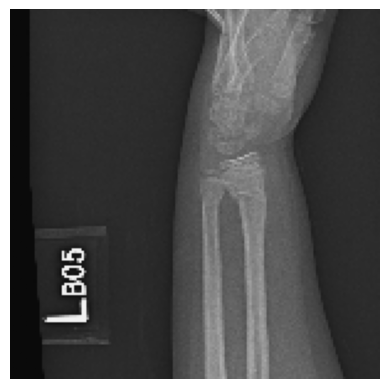

In [12]:
# Define a function to load images, resize, and normalize
def imageload(img_path, target_size=(150, 150)):
        # Load the image with specified target size and color mode
        img = load_img(img_path, target_size=target_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        return img_array


# Define the path to the images
image_folder = '/content/drive/MyDrive/AI2Assignment/BoneFracture/train/fractured/'

# Test loading an image in the "Fractured" class
image_path = os.path.join(image_folder, '119.jpg')
print('Class Fractured:')

# Load and display the image array
I1 = imageload(image_path)
plt.imshow(I1, cmap='gray')  # Use grayscale for X-ray images
plt.axis('off')  # Turn off axis
plt.show()


Feature Extraction usign LBP & SIFT

In [7]:
# Parameters for LBP
radius = 1
n_points = 8 * radius

# Define a function to extract LBP features
def extract_lbp_features(image, radius=radius, n_points=n_points):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Define a function to extract SIFT features
def extract_sift_features(image, vector_size=64):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is None:
        descriptors = np.zeros((vector_size, 128))
    elif len(descriptors) < vector_size:
        descriptors = np.concatenate([descriptors, np.zeros((vector_size - len(descriptors), 128))])
    else:
        descriptors = descriptors[:vector_size]

    return descriptors.flatten()

In [8]:
# Load images from a folder, extract features, and get labels
def load_dataset_and_extract_features(folder_path):
    labels = []
    lbp_features = []
    sift_features = []

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                image = cv2.imread(img_path)

                if image is None:
                    continue

                lbp_feat = extract_lbp_features(image)
                sift_feat = extract_sift_features(image)

                lbp_features.append(lbp_feat)
                sift_features.append(sift_feat)
                labels.append(class_folder)  # Use the folder name as the label

    lbp_features = np.array(lbp_features)
    sift_features = np.array(sift_features)
    labels = np.array(labels)

    combined_features = np.hstack([lbp_features, sift_features])

    return combined_features, labels

In [14]:
# Define paths for train and test datasets
train_folder = '/content/drive/MyDrive/AI2Assignment/BoneFracture/train'
test_folder = '/content/drive/MyDrive/AI2Assignment/BoneFracture/val'

# Extract features for train and test datasets
X_train, y_train = load_dataset_and_extract_features(train_folder)
X_test, y_test = load_dataset_and_extract_features(test_folder)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SVM Model

In [15]:
from sklearn.svm import SVC
# Train the SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict labels on the test set
y_pred_svm = svm.predict(X_test)
# Print accuracy
print("SVM Accuracy:", svm.score(X_test, y_test))

# Calculate and print precision and recall
precision_svm = precision_score(y_test, y_pred_svm,pos_label='fractured')
recall_svm = recall_score(y_test, y_pred_svm,pos_label='fractured')
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

SVM Accuracy: 0.6616666666666666
SVM Precision: 0.7198879551820728
SVM Recall: 0.7138888888888889


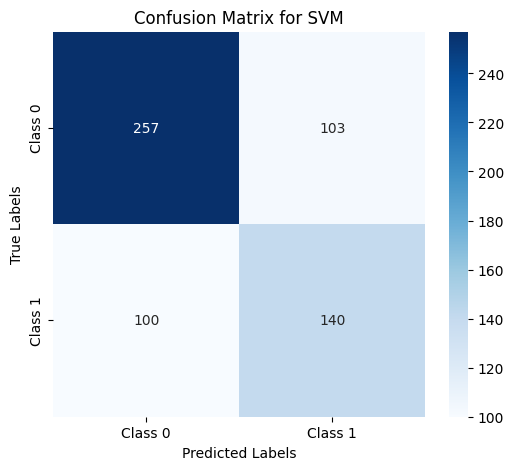

In [16]:
# Plot confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for SVM')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [18]:
joblib.dump(svm, 'svm_model.pkl')

['svm_model.pkl']

In [19]:
from google.colab import files
files.download('svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>